In [1]:
# Compatibility with Python 3
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

# Basic packages
import numpy as np
import os
import sys
import glob
import pickle
import astropy.io.fits as pyfits
import astropy.table as table
import scipy
from scipy.stats import norm
from scipy.interpolate import interp1d

# Matplotlib adjustments (you might not need all of these)
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.mlab as mlab
import matplotlib.cm as cmx
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.patches as mpatches
matplotlib.rc('text', usetex = True)
params = {'text.latex.preamble': [r'\usepackage{upgreek}', r'\usepackage{amsmath}'],'font.family' : 'lmodern','font.size' : 11}   
plt.rcParams.update(params)

# PARULA MAP
_parula_data = [[0.2081, 0.1663, 0.5292], 
                [0.2116238095, 0.1897809524, 0.5776761905], 
                [0.212252381, 0.2137714286, 0.6269714286], 
                [0.2081, 0.2386, 0.6770857143], 
                [0.1959047619, 0.2644571429, 0.7279], 
                [0.1707285714, 0.2919380952, 0.779247619], 
                [0.1252714286, 0.3242428571, 0.8302714286], 
                [0.0591333333, 0.3598333333, 0.8683333333], 
                [0.0116952381, 0.3875095238, 0.8819571429], 
                [0.0059571429, 0.4086142857, 0.8828428571], 
                [0.0165142857, 0.4266, 0.8786333333], 
                [0.032852381, 0.4430428571, 0.8719571429], 
                [0.0498142857, 0.4585714286, 0.8640571429], 
                [0.0629333333, 0.4736904762, 0.8554380952], 
                [0.0722666667, 0.4886666667, 0.8467], 
                [0.0779428571, 0.5039857143, 0.8383714286], 
                [0.079347619, 0.5200238095, 0.8311809524], 
                [0.0749428571, 0.5375428571, 0.8262714286], 
                [0.0640571429, 0.5569857143, 0.8239571429], 
                [0.0487714286, 0.5772238095, 0.8228285714], 
                [0.0343428571, 0.5965809524, 0.819852381], 
                [0.0265, 0.6137, 0.8135], 
                [0.0238904762, 0.6286619048, 0.8037619048], 
                [0.0230904762, 0.6417857143, 0.7912666667], 
                [0.0227714286, 0.6534857143, 0.7767571429], 
                [0.0266619048, 0.6641952381, 0.7607190476], 
                [0.0383714286, 0.6742714286, 0.743552381], 
                [0.0589714286, 0.6837571429, 0.7253857143], 
                [0.0843, 0.6928333333, 0.7061666667], 
                [0.1132952381, 0.7015, 0.6858571429], 
                [0.1452714286, 0.7097571429, 0.6646285714], 
                [0.1801333333, 0.7176571429, 0.6424333333], 
                [0.2178285714, 0.7250428571, 0.6192619048], 
                [0.2586428571, 0.7317142857, 0.5954285714], 
                [0.3021714286, 0.7376047619, 0.5711857143], 
                [0.3481666667, 0.7424333333, 0.5472666667], 
                [0.3952571429, 0.7459, 0.5244428571], 
                [0.4420095238, 0.7480809524, 0.5033142857], 
                [0.4871238095, 0.7490619048, 0.4839761905], 
                [0.5300285714, 0.7491142857, 0.4661142857], 
                [0.5708571429, 0.7485190476, 0.4493904762],
                [0.609852381, 0.7473142857, 0.4336857143], 
                [0.6473, 0.7456, 0.4188], 
                [0.6834190476, 0.7434761905, 0.4044333333], 
                [0.7184095238, 0.7411333333, 0.3904761905], 
                [0.7524857143, 0.7384, 0.3768142857], 
                [0.7858428571, 0.7355666667, 0.3632714286], 
                [0.8185047619, 0.7327333333, 0.3497904762], 
                [0.8506571429, 0.7299, 0.3360285714], 
                [0.8824333333, 0.7274333333, 0.3217], 
                [0.9139333333, 0.7257857143, 0.3062761905], 
                [0.9449571429, 0.7261142857, 0.2886428571], 
                [0.9738952381, 0.7313952381, 0.266647619], 
                [0.9937714286, 0.7454571429, 0.240347619], 
                [0.9990428571, 0.7653142857, 0.2164142857], 
                [0.9955333333, 0.7860571429, 0.196652381], 
                [0.988, 0.8066, 0.1793666667], 
                [0.9788571429, 0.8271428571, 0.1633142857], 
                [0.9697, 0.8481380952, 0.147452381], 
                [0.9625857143, 0.8705142857, 0.1309], 
                [0.9588714286, 0.8949, 0.1132428571], 
                [0.9598238095, 0.9218333333, 0.0948380952], 
                [0.9661, 0.9514428571, 0.0755333333], 
                [0.9763, 0.9831, 0.0538]]

from matplotlib.colors import ListedColormap

parula = ListedColormap(_parula_data, name='parula')
parula_zero = _parula_data[0]

In [2]:
output   = 'Cannon3.0.1'
DR       = 'dr5.2'
subset   = '_SMEmasks'

# Change Work directory (if Sven's computer)
try:
    localFilePath = '/shared-storage/buder/svn-repos/trunk/GALAH/'
    os.chdir(localFilePath)
except:
    print('Could not change Path to '+localFilePath)

# Exchange stellar parameters:

In [4]:
iteration_outlier = []

iterations = glob.glob('CANNON/'+DR+'/'+output+'/'+output+'_Sp'+subset+'*_model.pickle')

print('There are the following iterations available for exchange: ')
print(iterations)

print('I hence suggest subset SP to be called:')
subset_sp = subset+'_it'+str(len(iterations)-1)
print(subset_sp)

There are the following iterations available for exchange: 
['CANNON/dr5.2/Cannon3.0.1/Cannon3.0.1_Sp_SMEmasks_model.pickle', 'CANNON/dr5.2/Cannon3.0.1/Cannon3.0.1_Sp_SMEmasks_it1_model.pickle']
I hence suggest subset SP to be called:
_SMEmasks_it1


In [5]:
t = table.Table()
sme = t.read('CANNON/'+DR+'/'+output+'/trainingset/'+output+'_Sp'+subset_sp+'_trainingset.fits')

In [6]:
door = open('CANNON/'+DR+'/'+output+'/'+output+'_Sp'+subset_sp+'_selftest_tags.pickle')
sp_param, sp_e_param, sp_covs,sp_chi2_def,sp_ids,sp_chi2_good,sp_chi2_each = pickle.load(door)
door.close()

include_parameters = np.array(['Teff','Logg','Feh','Vmic','Vsini']) # 'Alpha_fe',
include_auxiliary  = np.array(['Ak']) # ['Ebv']
sp_labels = np.concatenate((include_parameters,include_auxiliary))

spectratotake = np.arange(len(sme['sobject_id']))

# Now we just exchange the SME derived parameters with the ones of the best Cannon model
for i,each in enumerate(sp_labels):
    sme[each] = sp_param[:,i]
        
print('Exchanged SME values with '+output+'_Sp_SMEmasks_it1_selftest_tags values')

sme.write('CANNON/'+DR+'/'+output+'/trainingset/'+output+'_Sp'+subset_sp+'_trainingset_exchanged.fits',overwrite=True)

Exchanged SME values with Cannon3.0.1_Sp_SMEmasks_it1_selftest_tags values


In [ ]:
possible_abundances = np.array(['Li','C','O','Na','Mg','Al','Al6696','Al7835','Si','K','K5802','K7699','Ca','Sc','Ti','V','Cr','Mn','Co','Ni','Cu','Cu5700','Cu5782','Zn','Rb','Sr','Y','Zr','Mo','Ru','Ba','Ba5854','Ba6497','La','Ce','Nd','Sm','Eu'])

for mode in possible_abundances:

    os.system('rm CANNON/'+DR+'/'+output+'/trainingset/'+output+'_'+mode+subset+'_trainingset.fits')
    
    sme = t.read('CANNON/'+DR+'/'+output+'/trainingset/'+output+'_Sp'+subset_sp+'_trainingset_exchanged.fits')
    
    good_abundances = (
        np.isfinite(sme[mode+'_abund_sme']) & 
        (sme['flag_'+mode+'_abund_sme'] == 0) &
        (sme['e_'+mode+'_abund_sme'] < 0.15)
        )

    nspectra = np.arange(len(sme['sobject_id']))
    sme.remove_rows(nspectra[~good_abundances])
    
    if len(sme['sobject_id']) > 0:
        sme.write('CANNON/'+DR+'/'+output+'/trainingset/'+output+'_'+mode+subset+'_trainingset.fits',overwrite=True)

/home/buder/.local/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in less


Li 1567
C 1204
O 8538
Na 10222
Mg 10470
Al 8529
Al6696 1246
Al7835 1046
Si 9106
K 10237
K5802 103
K7699 10237
Ca 9217
Sc 10438
Ti 10335
V 6973
Cr 10015
Mn 10204
Co 5574
Ni 10189
Cu 9312


/usr/lib64/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Cu5700 1409
Cu5782 9312
Zn 10012
Rb 1074
Sr 722
Y 9354
Zr 4040
Mo 1587
Ru 1658
Ba 10417
Ba5854 9944
Ba6497 9040
La 5215
Ce 4116
Nd 3576
Sm 1018
Eu 4419


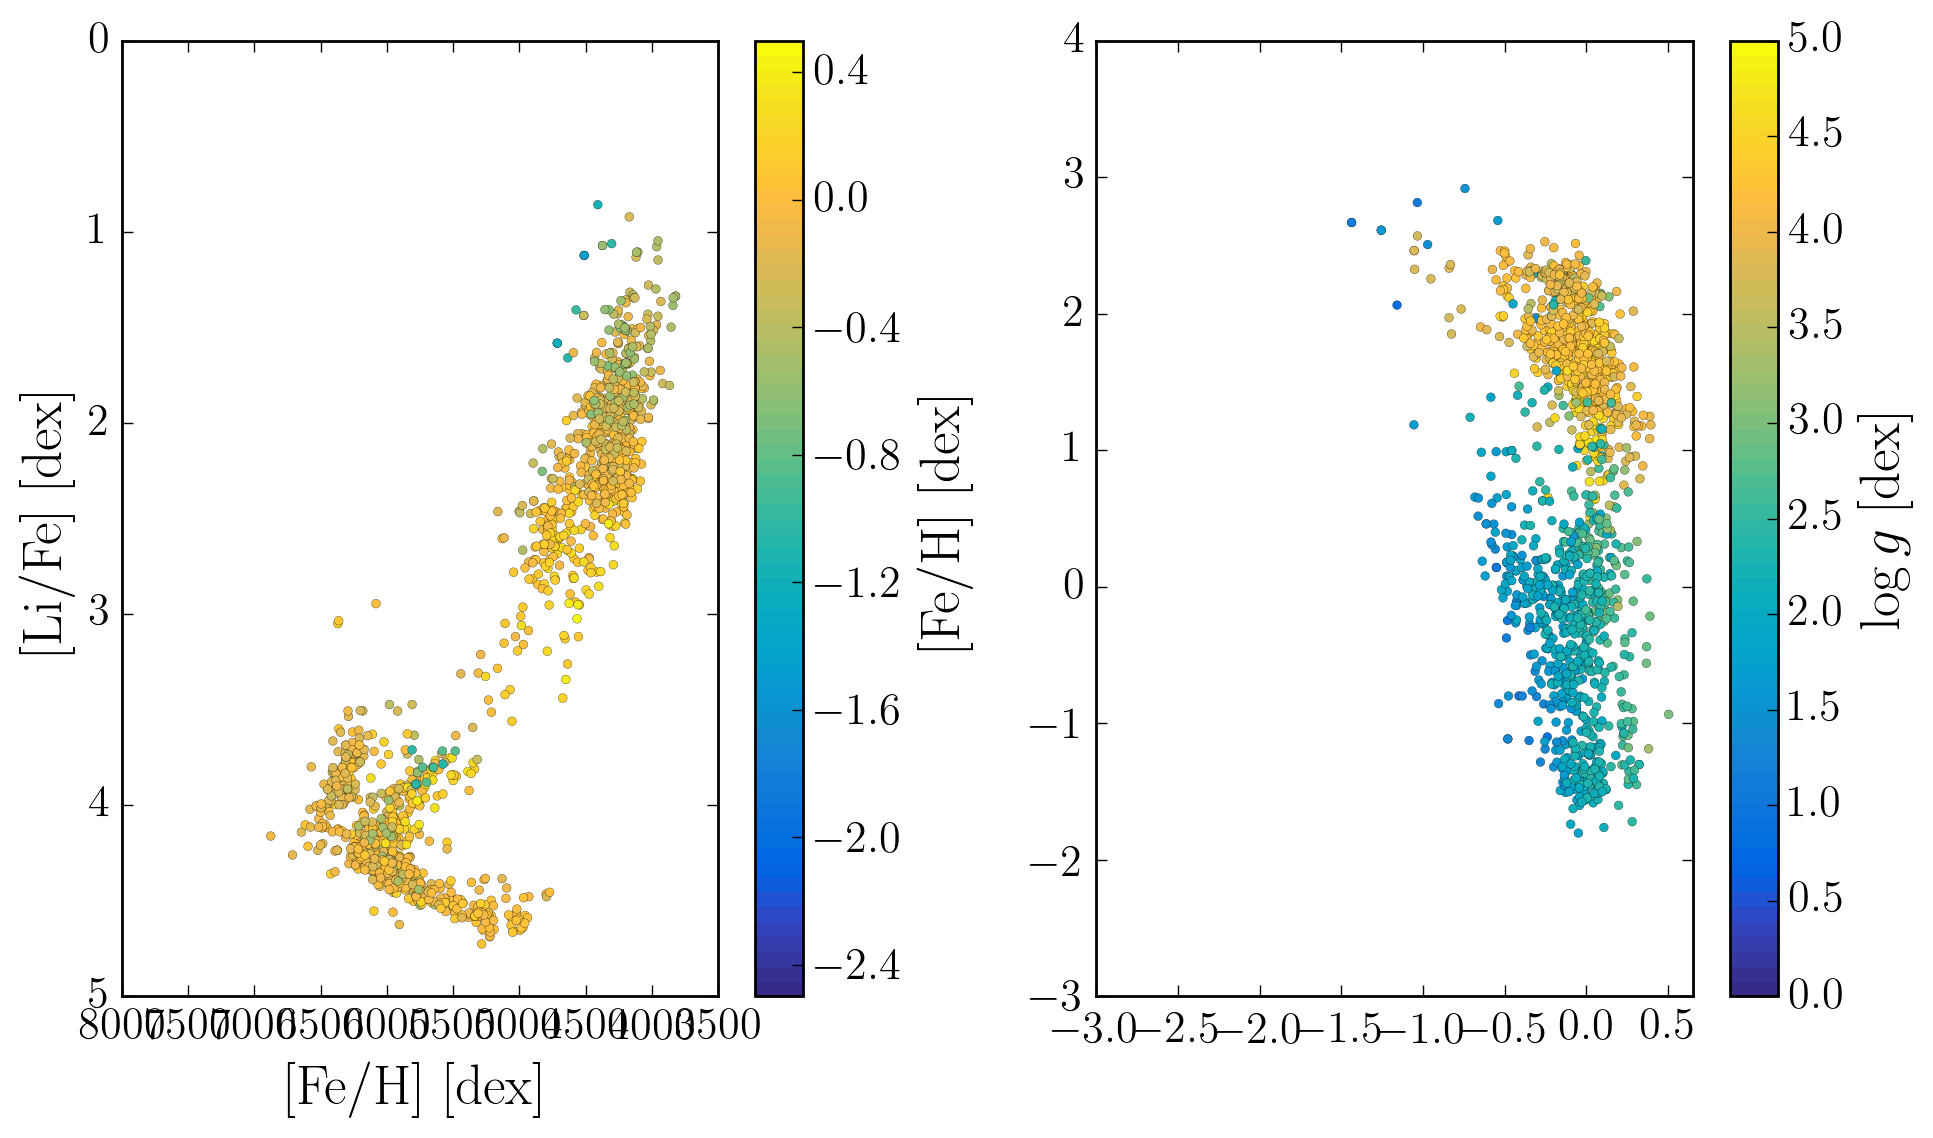

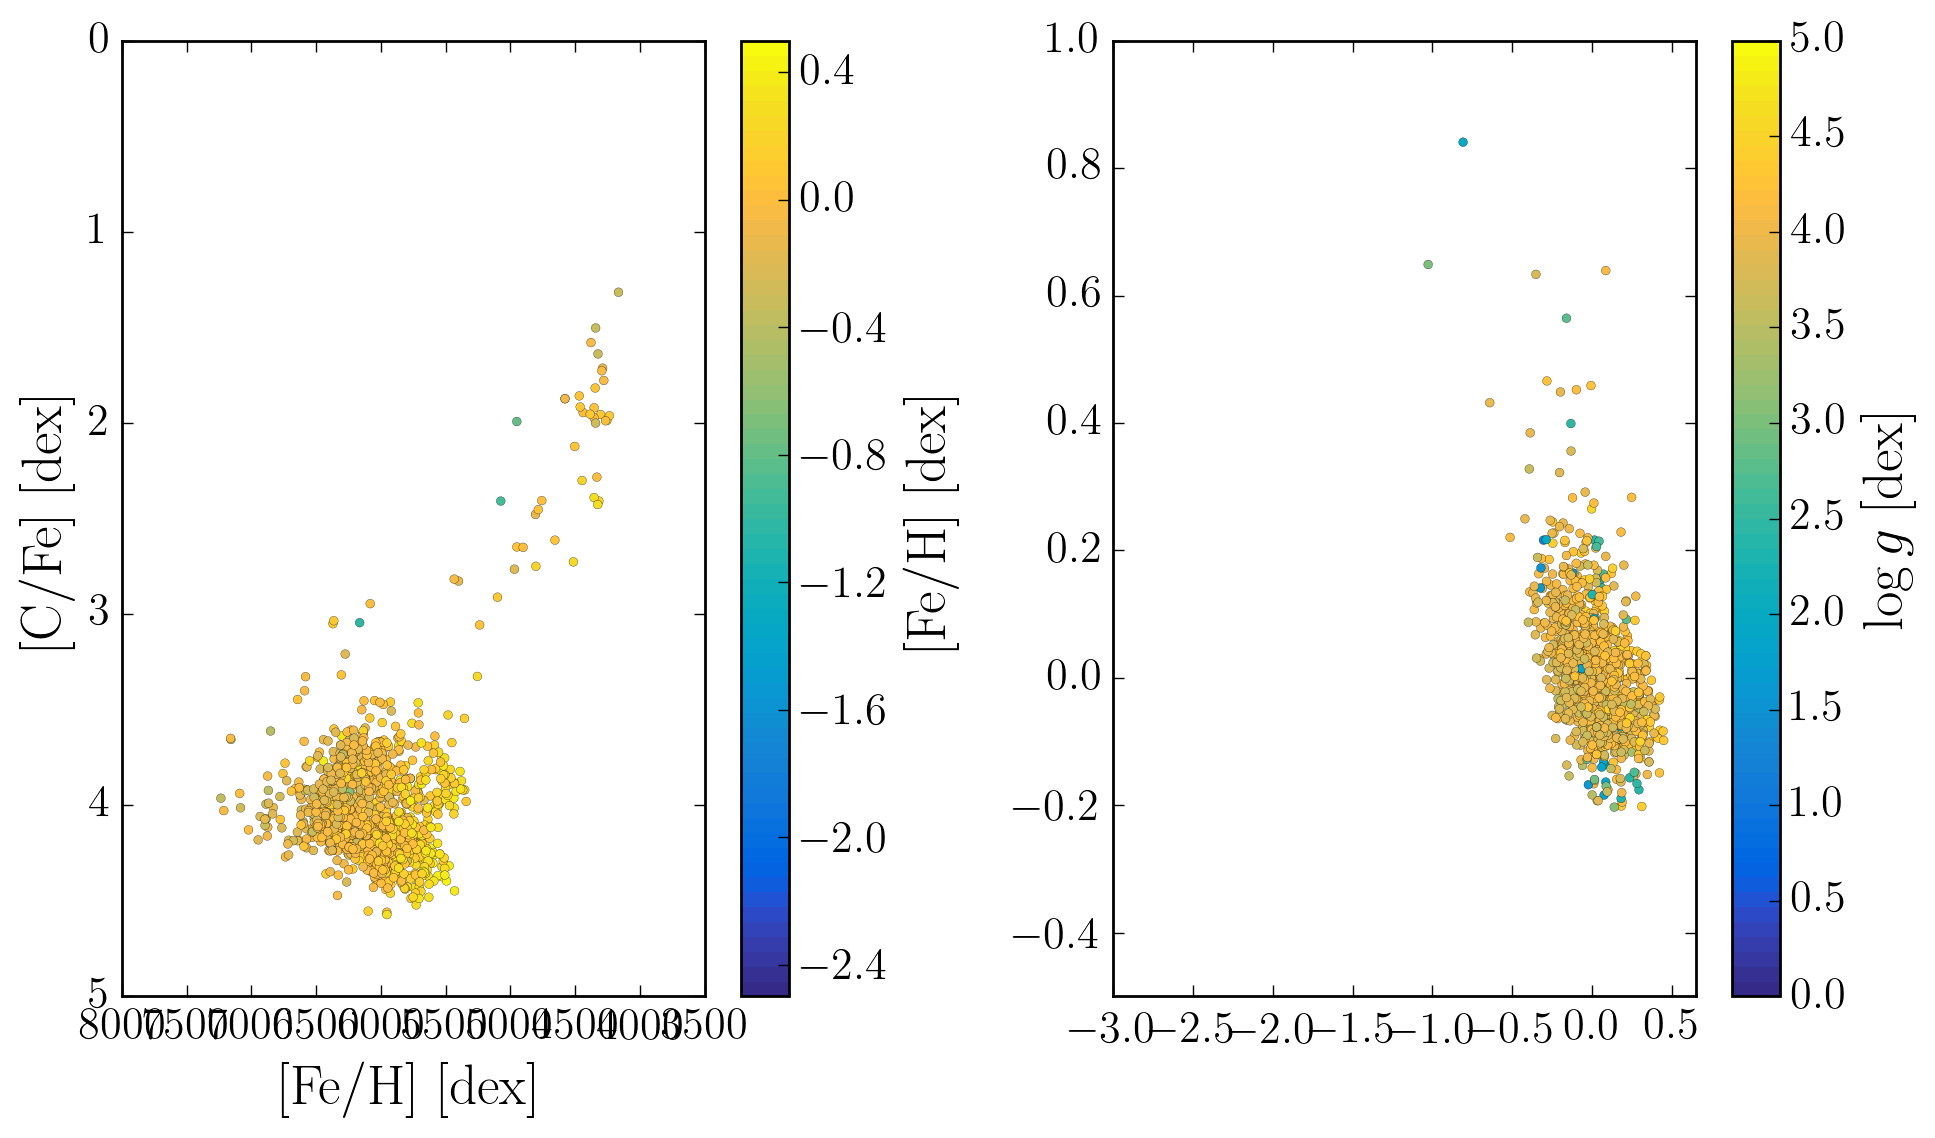

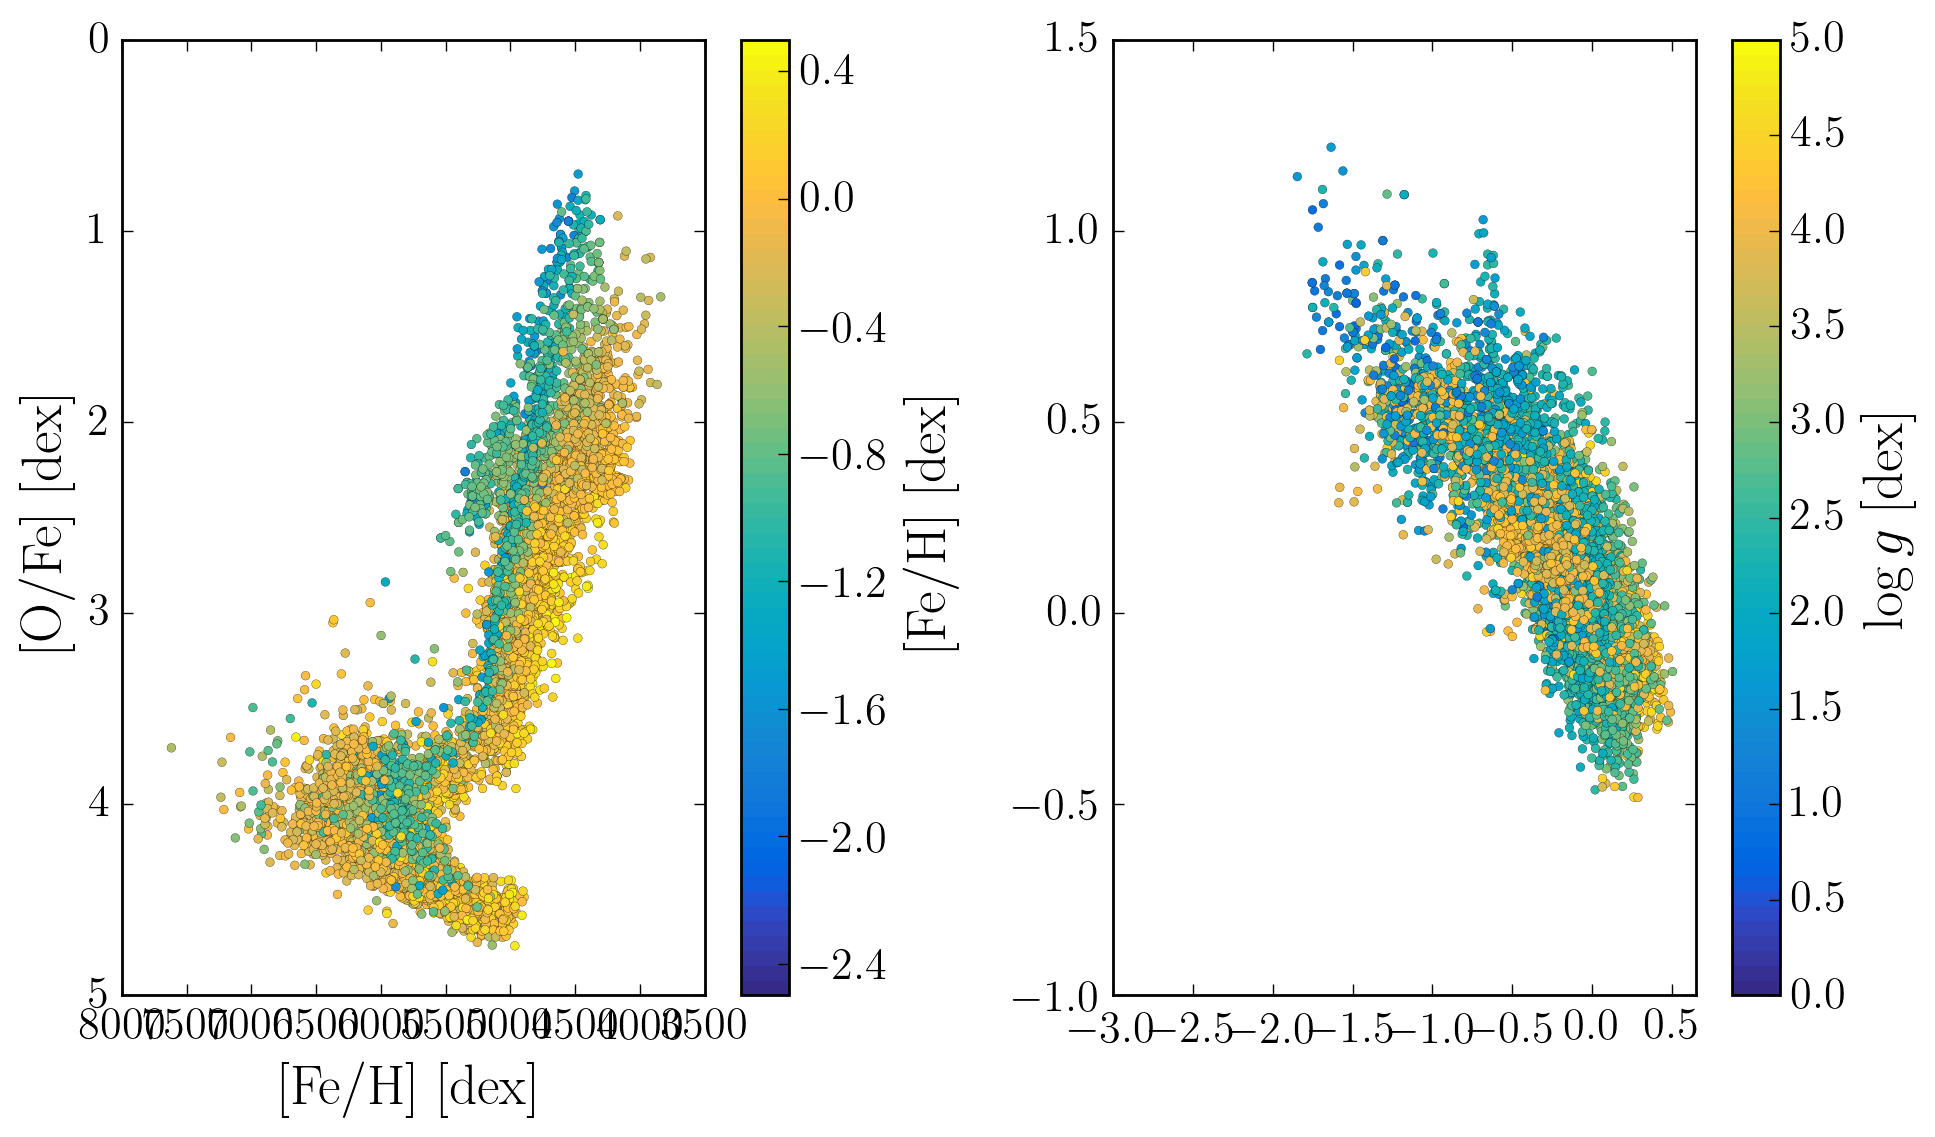

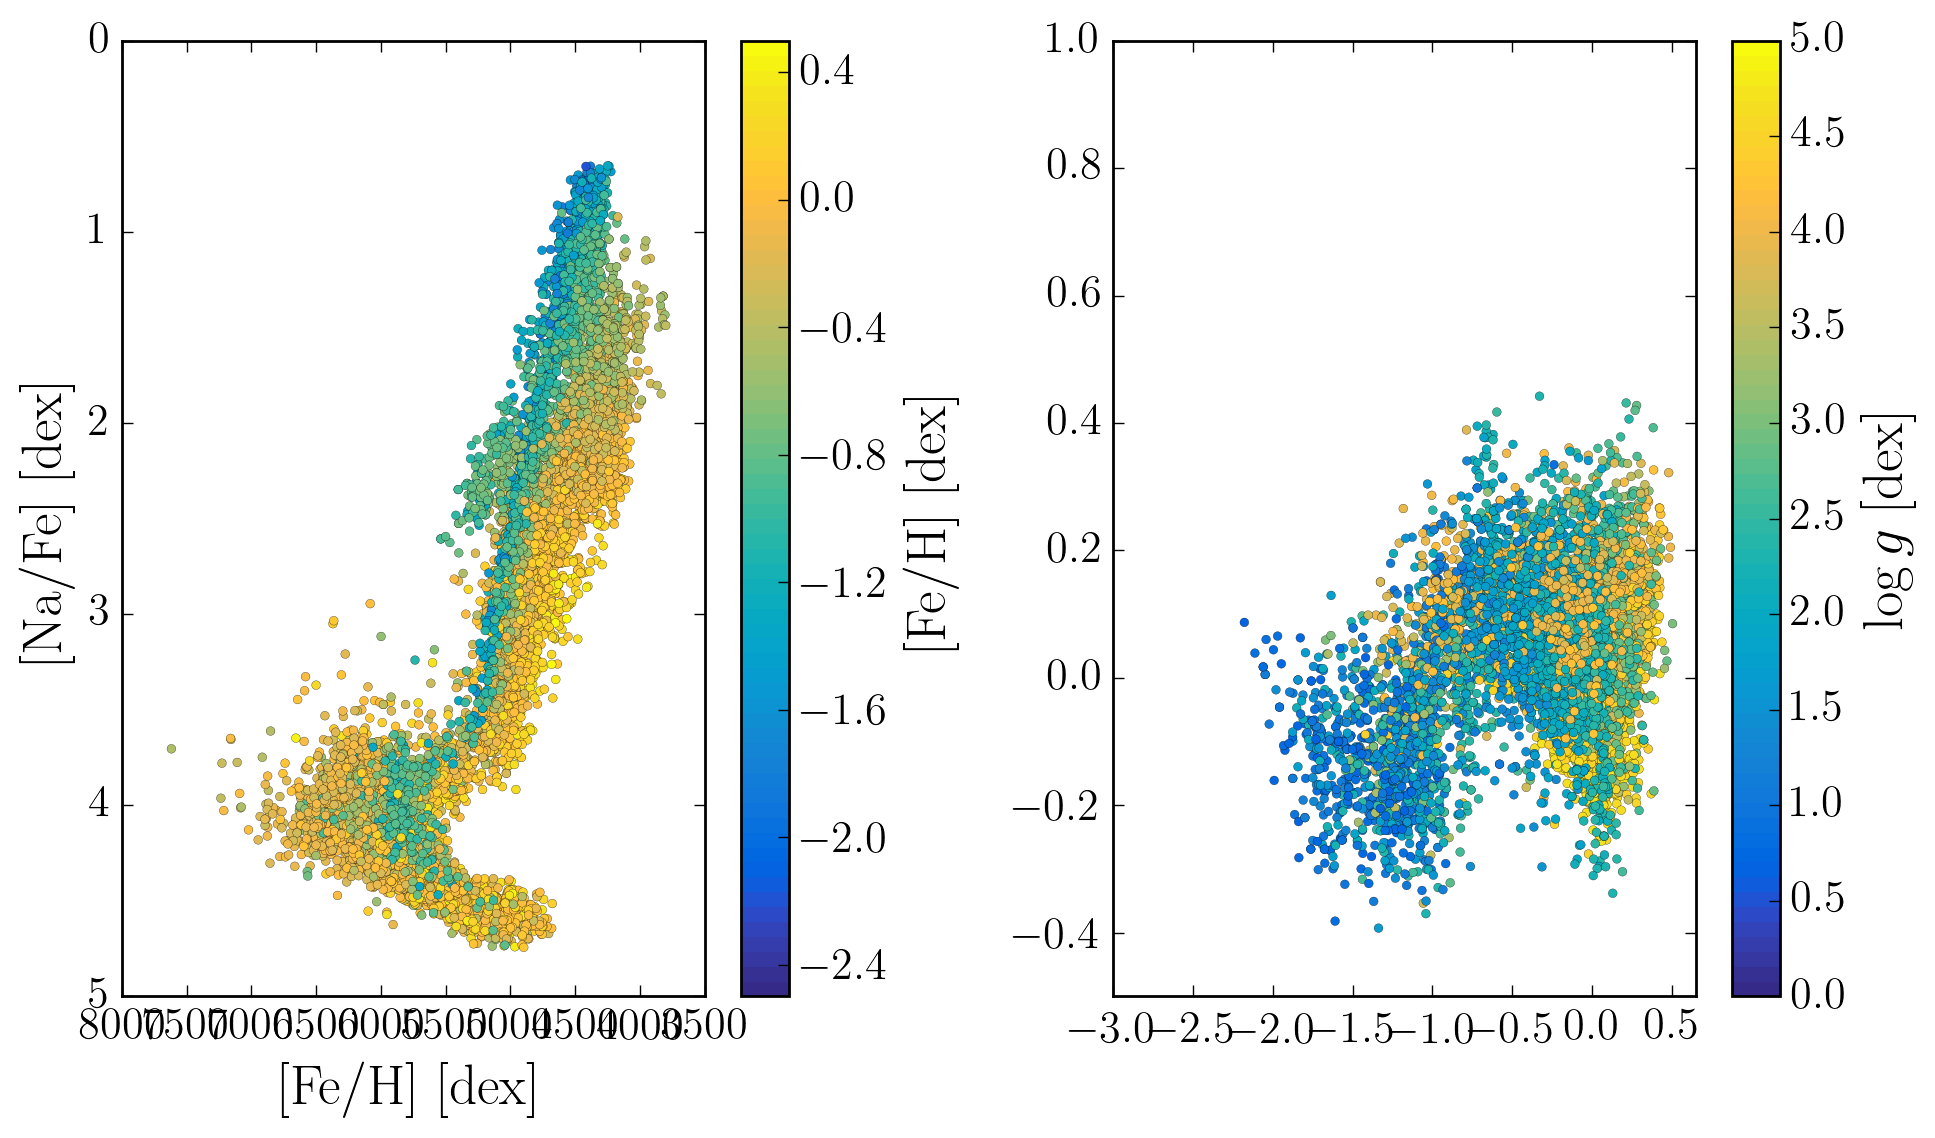

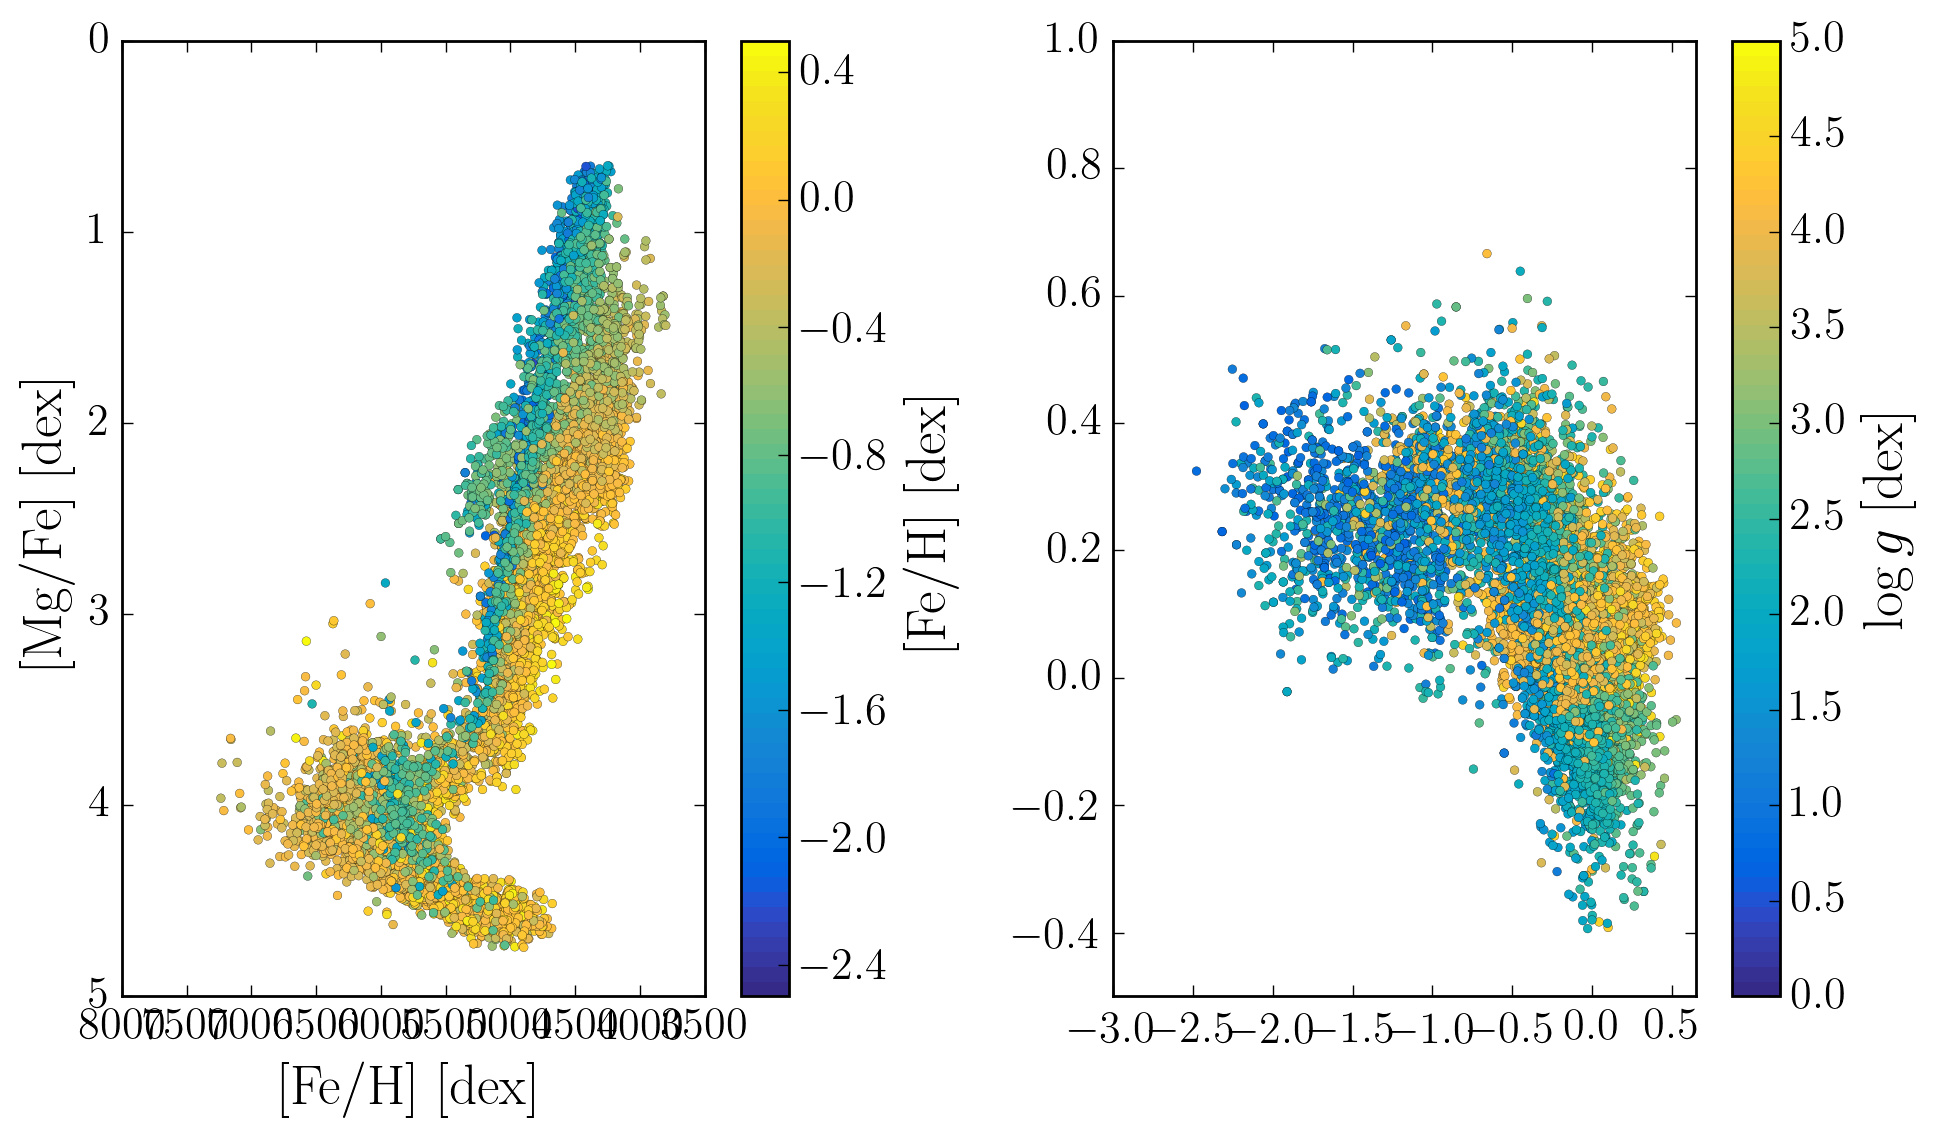

In [ ]:
plt.rcParams['font.family'] = 'lmodern'
plt.rcParams['font.size']       = 17
plt.rcParams['axes.labelsize']  = 20
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 20

for mode in possible_abundances:
    sme = t.read('CANNON/'+DR+'/'+output+'/trainingset/'+output+'_'+mode+subset+'_trainingset.fits')
    
    print(mode,len(sme['sobject_id']))
    
    f,(ax1,ax2) = plt.subplots(1,2)
    kwargs = dict(cmap = parula, s = 10, lw=0.1)
    s1=ax1.scatter(sme['Teff_sme'],sme['Logg_sme'],c=sme['Feh_sme'],vmin=-2.5, vmax=0.5,**kwargs)
    c1=plt.colorbar(s1,ax=ax1)
    c1.set_label(r'$\mathrm{[Fe/H]~[dex]}$')
    ax1.set_xlim(8000,3500)
    ax1.set_ylim(5,0)
    s2=ax2.scatter(sme['Feh_sme'],sme[mode+'_abund_sme'],c=sme['Logg_sme'],vmin=0,vmax=5,**kwargs)
    c2=plt.colorbar(s2,ax=ax2)
    c2.set_label(r'$\log g~\mathrm{[dex]}$')
    ax2.set_xlim(-3.0,0.65)
    if mode == 'Li':
        ax2.set_ylim=(-2,3)
    elif mode in ['Al','O','K','La','Eu','Mo','Ru','V','Zr']:
        ax2.set_ylim=(-0.5,1.5)
    elif mode in ['Ba','Y']:
        ax2.set_ylim(-1.00,2.00)
    elif mode in ['Ce','Cu','Mn','Nd','Rb','Sm']:
        ax2.set_ylim(-1.00,1.00)
    else:
        ax2.set_ylim(-0.5,1.00)
    ax1.set_xlabel(r'$T_\text{eff}~\mathrm{[K]}$')
    ax1.set_ylabel(r'$\log g~\mathrm{[dex]}$')
    ax1.set_xlabel(r'$\mathrm{[Fe/H]~[dex]}$')
    ax1.set_ylabel(r'$\mathrm{['+mode+r'/Fe]~[dex]}$')
    plt.tight_layout()
    plt.savefig('CANNON/'+DR+'/'+output+'/trainingset/'+output+'_'+mode+subset+'_trainingset.pdf')